In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
train_data = pd.read_csv('train_six_way.csv')
val_data = pd.read_csv('valid_six_way.csv')
test_data = pd.read_csv('test_six_way.csv')

In [3]:
# Inspect data to identify relevant columns
print(train_data.head())

   label                                          statement
0      1  Says the Annies List political group supports ...
1      3  When did the decline of coal start? It started...
2      4  Hillary Clinton agrees with John McCain "by vo...
3      1  Health care reform legislation is likely to ma...
4      3  The economic turnaround started at the end of ...


In [4]:
# Extract features and labels
X_train = train_data['statement']
y_train = train_data['label']
X_val = val_data['statement']
y_val = val_data['label']
X_test = test_data['statement']
y_test = test_data['label']


In [5]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)
X_test_vectorized = vectorizer.transform(X_test)

In [6]:
# Perform Randomized Search to find best hyperparameters for Logistic Regression
param_dist_lr = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 300, 400]
}

start_lr = time.time()
random_search_lr = RandomizedSearchCV(estimator=LogisticRegression(random_state=42),
                                      param_distributions=param_dist_lr,
                                      n_iter=20,
                                      cv=5,
                                      scoring='accuracy',
                                      n_jobs=-1,
                                      random_state=42,
                                      return_train_score=True)

random_search_lr.fit(X_train_vectorized, y_train)
end_lr = time.time()
print(f"Logistic Regression Randomized Search Time: {end_lr - start_lr:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Logistic Regression Randomized Search Time: 68.56 seconds


In [7]:
# Extract best estimator for Logistic Regression
best_lr = random_search_lr.best_estimator_

# Calculate train and validation losses
train_loss = log_loss(y_train, best_lr.predict_proba(X_train_vectorized))
val_loss = log_loss(y_val, best_lr.predict_proba(X_val_vectorized))

print(f"\nTrain Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Train Loss: 1.3127
Validation Loss: 1.6713



=== LogisticRegression Performance ===
Accuracy: 0.2723
F1-Score: 0.2691
Precision: 0.2767
Recall: 0.2723

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.18      0.25        92
           1       0.31      0.37      0.34       249
           2       0.24      0.16      0.19       212
           3       0.23      0.28      0.25       265
           4       0.23      0.26      0.25       241
           5       0.32      0.32      0.32       208

    accuracy                           0.27      1267
   macro avg       0.29      0.26      0.27      1267
weighted avg       0.28      0.27      0.27      1267



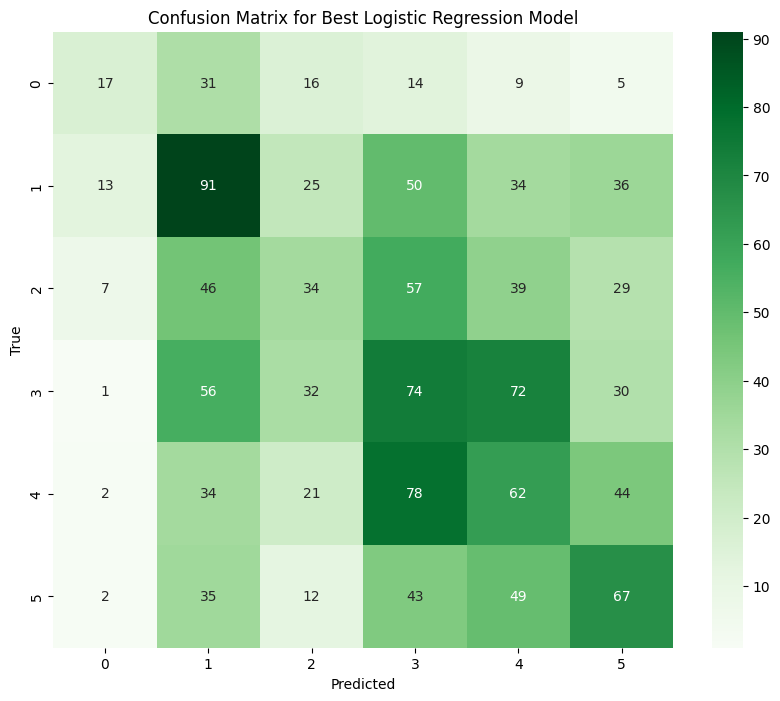


Logistic Regression Results:
{'Model': 'LogisticRegression', 'Best Params': {'max_iter': 100, 'C': 1}, 'CV Accuracy': 0.263671875, 'Test Accuracy': 0.27229676400947117, 'Test F1-Score': 0.26913516418454364, 'Precision': 0.2766752498533491, 'Recall': 0.27229676400947117, 'Training Time (s)': 68.56, 'Train Loss': 1.3127463561497266, 'Validation Loss': 1.6712997914085936}


In [8]:
# Evaluate on test set
y_test_pred_lr = best_lr.predict(X_test_vectorized)

acc_lr = accuracy_score(y_test, y_test_pred_lr)
f1_lr = f1_score(y_test, y_test_pred_lr, average='weighted')
precision_lr = precision_score(y_test, y_test_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_test_pred_lr, average='weighted')

print(f"\n=== LogisticRegression Performance ===")
print(f"Accuracy: {acc_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lr))

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.show()

lr_results = {
    'Model': 'LogisticRegression',
    'Best Params': random_search_lr.best_params_,
    'CV Accuracy': random_search_lr.best_score_,
    'Test Accuracy': acc_lr,
    'Test F1-Score': f1_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'Training Time (s)': round(end_lr - start_lr, 2),
    'Train Loss': train_loss,
    'Validation Loss': val_loss
}

print("\nLogistic Regression Results:")
print(lr_results)